In [1]:
import warnings

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn

warnings.simplefilter("ignore")
plt.style.use("ggplot")

In [2]:
eng = nivapy.da.connect()

Username:  ········
Password:  ········


Connection successful.


# RID seasonal loads

See e-mail from Øyvind K received 04.04.2025 at 11:03. For the period from 1990 to 2023, we need to estimate loads for Glomma, Drammenselva, Numedalslågen and Skienselva for the following parameters: SPM, Si, TOC, Tot-P, PO4, Tot-N, NH4 and NO3. Water discharge is also of interest.

For each site and parameter, we want to estimate **seasonal** fluxes, with seasons defined as: winter - DJF; spring - MAM; summer - JJA; and autumn - SON.

Note the following:

 * The load estimation method used for OSPAR/Elveovervåkingsprogrammet is designed for annual loads, so we'll need to use a different approach here. The summed seasonal loads will therefore not exactly match the annual loads reported under Elveovervåkingsprogrammet.
   
 * For Elveovervåkingsprogammet, we typically collect 12 to 16 water samples per year, which means 3 to 4 samples per season. This is not enough for robust load estimation, so results will have high uncertainty.

 * The series for SiO2 and Si should be merged into a single series (i.e. convert SiO2 to Si and combine). See e-mail from Øyvind received 16.04.2025.

## 1. User options

In [3]:
stn_dict = {
    29617: "Glomma",
    29612: "Drammenselva",
    29615: "Numedalslågen",
    29613: "Skienselva",
}
par_list = ["SPM", "SiO2", "Si", "TOC", "TOTP", "PO4-P", "TOTN", "NH4-N", "NO3-N"]
st_yr, end_yr = 1990, 2023

res_csv = r"../data/seasonal_loads/ytre_oslofjord_seasonal_loads.csv"

## 2. Get water chemistry data

In [4]:
stn_ids = list(stn_dict.keys())

par_df = nivapy.da.select_resa_station_parameters(
    stn_ids, f"{st_yr}-01-01", f"{end_yr}-12-31", eng
).query("parameter_name in @par_list")

wc_df, dup_df = nivapy.da.select_resa_water_chemistry(
    stn_ids,
    par_df,
    f"{st_yr}-01-01",
    f"{end_yr}-12-31",
    eng,
    lod_flags=False,
    drop_dups=False,
)
del wc_df["depth1"], wc_df["depth2"]

unit_dict = {
    "NH4-N_µg/l N": "NH4-N_ug/l",
    "NO3-N_µg/l N": "NO3-N_ug/l",
    "PO4-P_µg/l P": "PO4-P_ug/l",
    "SiO2_mg SiO2/l": "SiO2_mg/l",
    "TOC_mg C/l": "TOC_mg/l",
    "TOTN_µg/l N": "TOTN_ug/l",
    "TOTP_µg/l P": "TOTP_ug/l",
}
wc_df = wc_df.rename(columns=unit_dict)

# Convert SiO2 to Si
wc_df["SiEst_mg/l"] = wc_df["SiO2_mg/l"] * 28.086 / (28.086 + 15.999 + 15.999)

# Average Si values where we have both Si and SiO2
wc_df["SiEst_mg/l"] = wc_df[["Si_mg/l", "SiEst_mg/l"]].mean(axis="columns")

id_cols = ["station_id", "station_code", "station_name", "sample_date"]
par_cols = sorted([col for col in wc_df.columns if col not in id_cols])
wc_df = wc_df[id_cols + par_cols]
wc_df = wc_df.groupby(id_cols).mean().reset_index()
wc_df_long = wc_df.melt(id_vars=id_cols, var_name="par").dropna()

67 parameters available for the selected stations and dates.
WARNING
The database contains unexpected duplicate values for some station-date-parameter combinations.
Only the most recent values will be used, but you should check the repeated values are not errors.
The duplicated entries are returned in a separate dataframe.



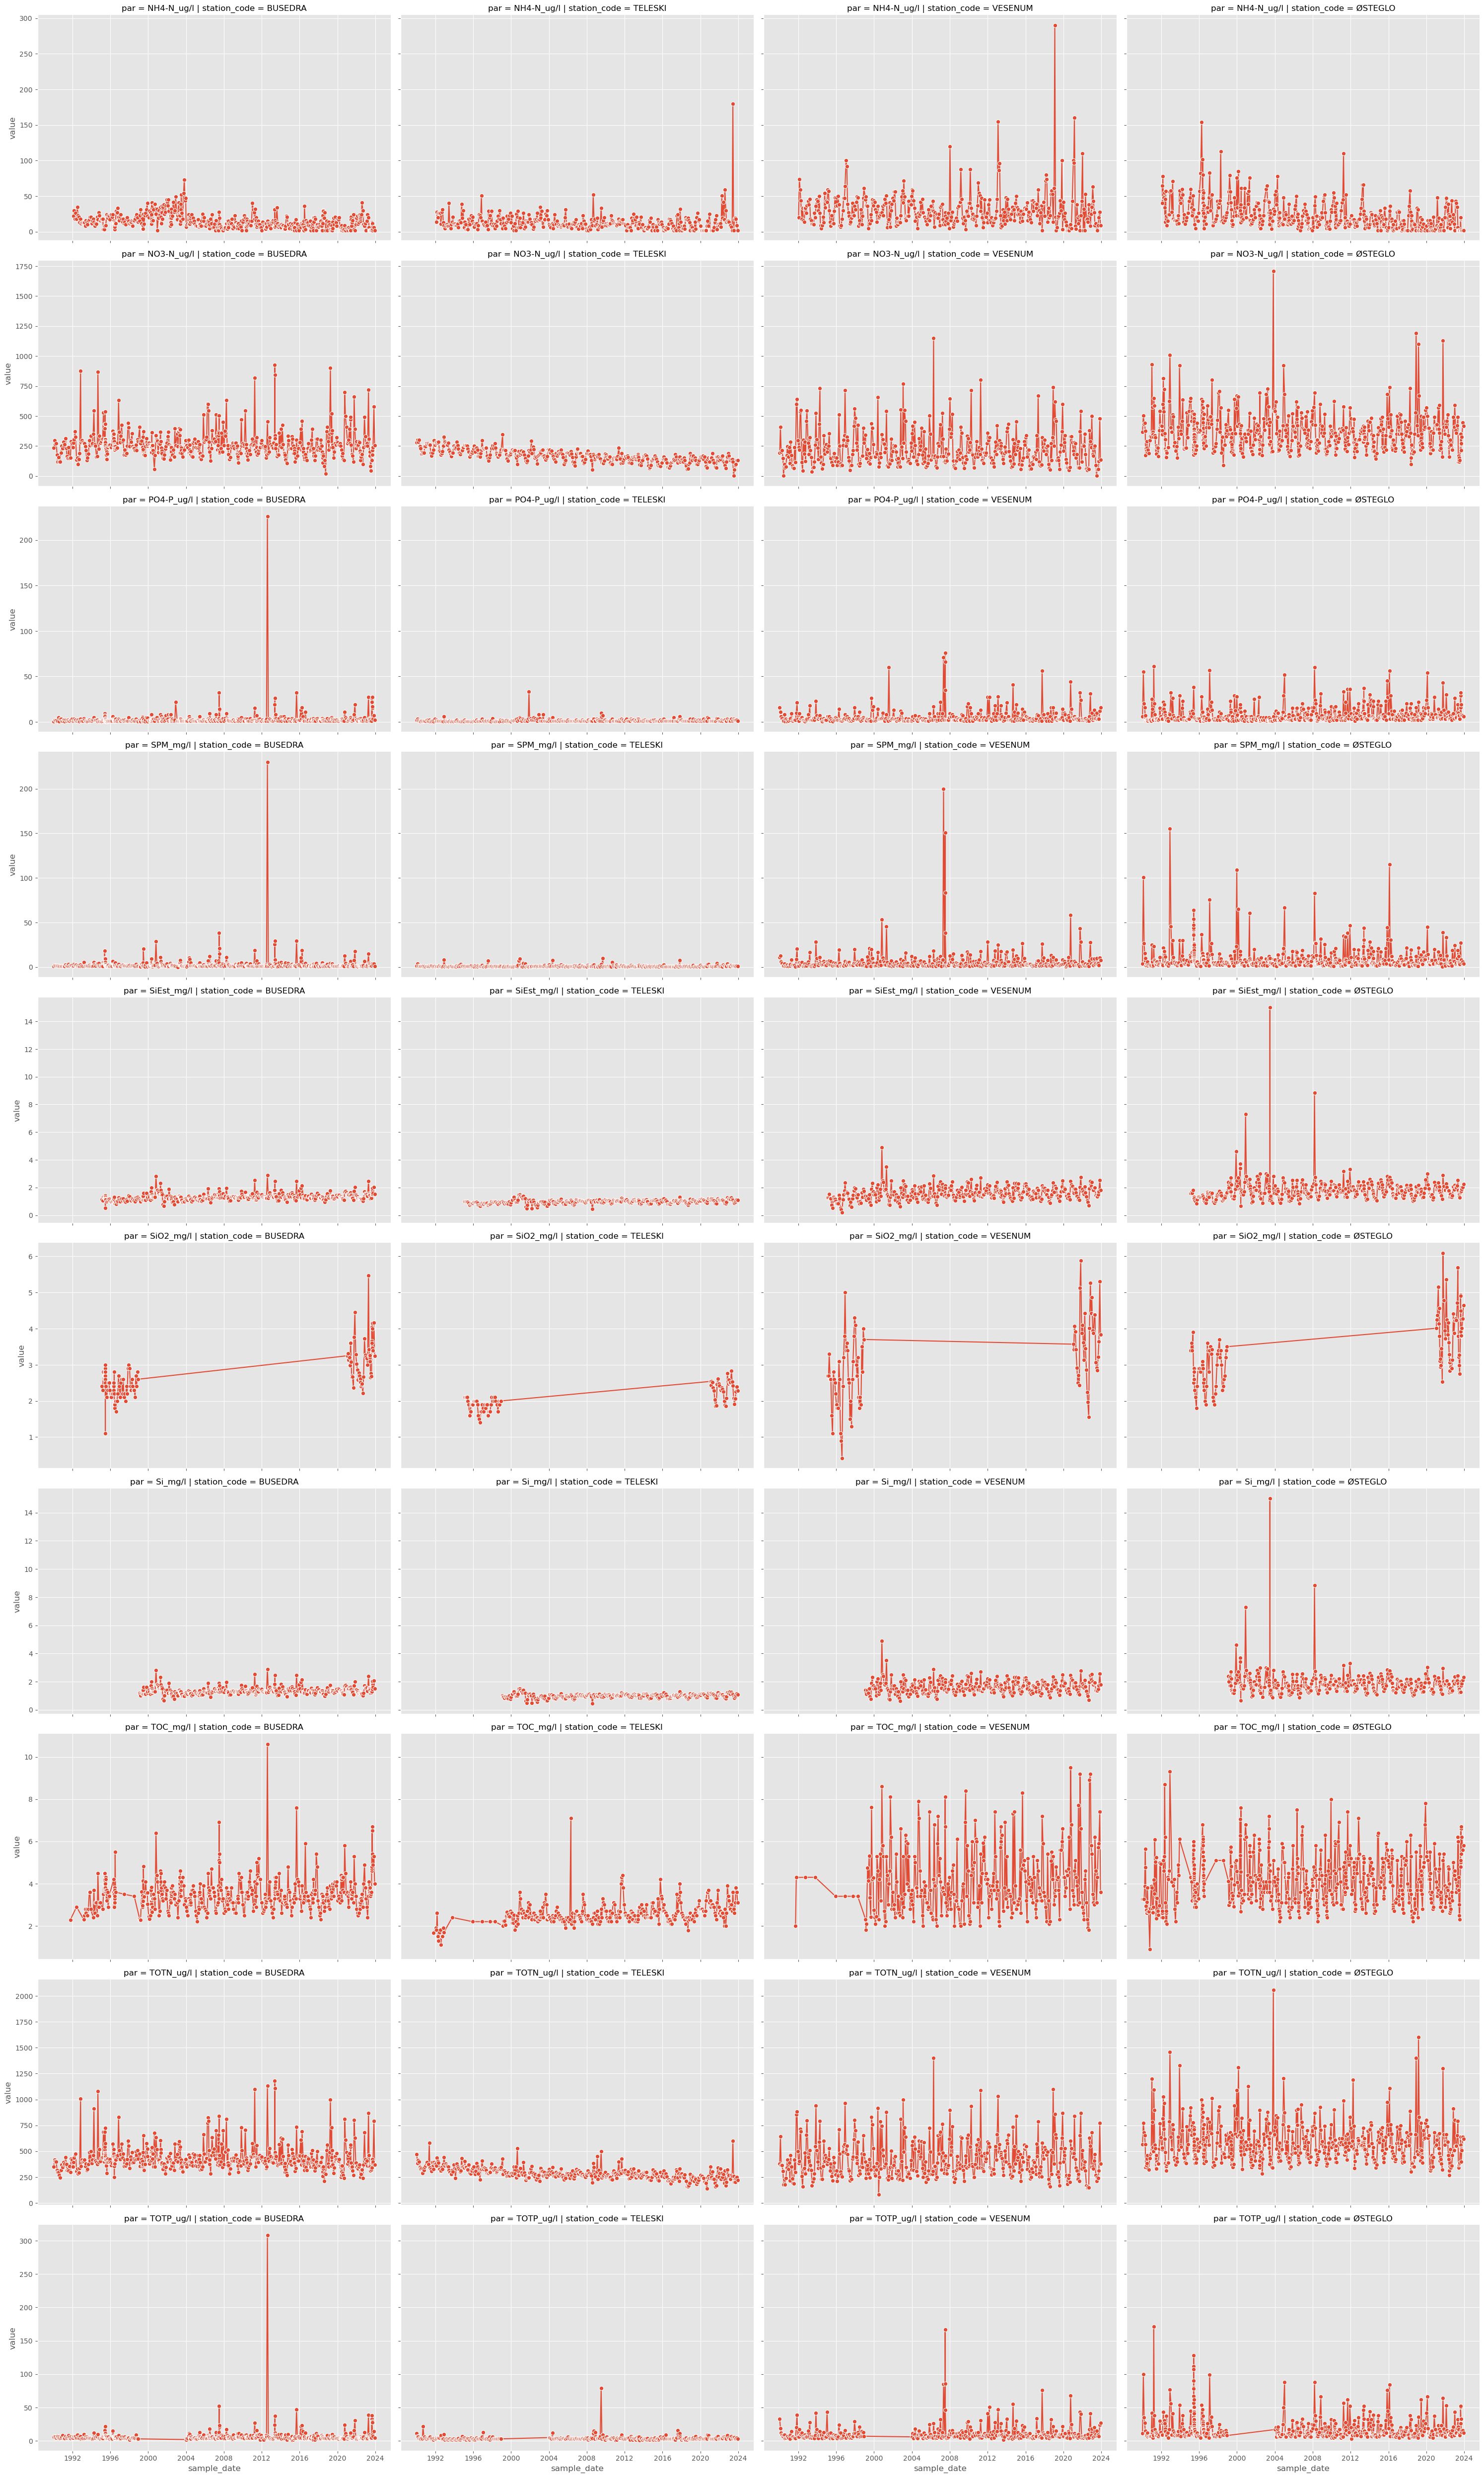

In [5]:
sn.relplot(
    wc_df_long,
    x="sample_date",
    y="value",
    row="par",
    col="station_code",
    kind="line",
    marker="o",
    facet_kws={"sharey": "row", "sharex": True},
    aspect=1.5,
)
plt.savefig("../plots/rid_concs_1990-2023.png", dpi=200, bbox_inches="tight")

## 3. Estimate seasonal loads

In [6]:
# Use just the merged series for Si
wc_df.drop(columns=["SiO2_mg/l", "Si_mg/l"], inplace=True)
wc_df.rename(columns={"SiEst_mg/l": "Si_mg/l"}, inplace=True)

df_list = []
stn_cols = ["station_id", "station_code", "station_name"]
for (stn_id, stn_code, stn_name), stn_df in wc_df.groupby(stn_cols):
    stn_df = stn_df.drop(columns=stn_cols).set_index("sample_date")

    q_df = nivapy.da.extract_resa_discharge(
        int(stn_id), f"{st_yr}-01-01", f"{end_yr}-12-31", eng, plot=False
    )

    load_df = nivapy.stats.estimate_fluxes(
        q_df,
        stn_df,
        base_freq="D",
        agg_freq="Q-FEB",
        method="linear_interpolation",
        st_date=None,
        end_date=None,
        plot_fold=None,
    ).reset_index()

    # The first and last periods are incomplete, so drop
    load_df = load_df.iloc[1:-1]

    res_cols = list(load_df.columns)
    load_df["station_id"] = stn_id
    load_df["station_code"] = stn_code
    load_df["station_name"] = stn_name

    load_df = load_df[stn_cols + res_cols]
    df_list.append(load_df)

load_df = pd.concat(df_list, axis="rows").reset_index(drop=True)

# Round all float columns to the nearest integer
load_df_rounded = load_df.select_dtypes(include=["float"]).round().astype(int)
load_df[load_df_rounded.columns] = load_df_rounded

# Convert kg to tonnes
for col in load_df.columns:
    if col.endswith("_kg"):
        new_col = col.replace("_kg", "_tonnes")
        load_df[new_col] = load_df[col] / 1000
        del load_df[col]

# Save
load_df.to_csv(res_csv, index=False)

load_df.head()

,station_id,station_code,station_name,date,flow_m3,NH4-N_tonnes,NO3-N_tonnes,PO4-P_tonnes,SPM_tonnes,Si_tonnes,TOC_tonnes,TOTN_tonnes,TOTP_tonnes
0,29612,BUSEDRA,Drammenselva,1990-05-31,2801997303,61.644,673.867,3.414,4102.057,3143.475,6416.574,1053.856,15.825
1,29612,BUSEDRA,Drammenselva,1990-08-31,2381513970,52.393,326.026,6.645,3075.112,2671.748,5453.667,691.940,14.361
2,29612,BUSEDRA,Drammenselva,1990-11-30,2063648047,45.400,402.460,4.417,1968.504,2315.144,4725.754,658.541,10.910
3,29612,BUSEDRA,Drammenselva,1991-02-28,2266769884,49.869,581.537,3.503,2312.931,2543.020,5190.903,843.728,12.610
4,29612,BUSEDRA,Drammenselva,1991-05-31,2339713683,51.474,626.322,3.052,4003.009,2624.853,5357.944,930.524,12.903


## 4. Compare to annual loads reported under Elveovervåkingsprogrammet

**Seasonal load estimates using linear interpolation with ~3 data points per season are not robust**. The code below sums the seasonal estimates for each year and compares these results to annual loads reported under Elveovervåkingsprogrammet. Results are similar, but not the same. Note the following:

 1. Elveovervåkingsprogrammet uses a "ratio estimator" designed for calculating annual loads. This is more robust than the "linear interpolation" method used here for the seasonal loads (but it can't be used for seasonal loads with small numbers of data points).
    
 2. Elveovervåkingsprogrammet includes a correction for values at the limit of detection. I have not implemented this for the seasonal load calculations here. Instead, LOD values are assumed to be equal to the LOD.

In [7]:
ann_df = load_df.copy()
ann_df["year"] = ann_df["date"].dt.year
del ann_df["date"]
ann_df = (
    ann_df.groupby(["station_id", "station_code", "station_name", "year"])
    .sum()
    .reset_index()
)
ann_df["mean_q_1000m3/day"] = ann_df["flow_m3"] / (1000 * 365.25)
del ann_df["flow_m3"]

# Data for first and last years is not complete, so remove from comparison
ann_df = ann_df.query("@st_yr < year < @end_yr")

# Convert to long
cols = ann_df.columns
ann_df = ann_df.melt(
    id_vars=["station_id", "station_code", "station_name", "year"],
    var_name="par",
    value_name="annual_sum_seasonal",
)

# Read "official" estimates reported under Elveovervåkingsprogrammet
stn_ids = list(stn_dict.keys())
csv_path = r"/home/jovyan/shared/common/elveovervakingsprogrammet/results/measured_loads/loads_and_flows_rid_20_1990-2023.csv"
rid_df = pd.read_csv(csv_path).query("station_id in @stn_ids")[cols]
rid_df = rid_df.query("@st_yr < year < @end_yr")
del rid_df["station_code"], rid_df["station_name"]
rid_df = rid_df.melt(
    id_vars=["station_id", "year"], var_name="par", value_name="rid_annual"
)

# Combine
ann_df = pd.merge(
    ann_df,
    rid_df,
    on=["station_id", "par", "year"],
    how="inner",
)

ann_df.head()

,station_id,station_code,station_name,year,par,annual_sum_seasonal,rid_annual
0,29612,BUSEDRA,Drammenselva,1991,NH4-N_tonnes,157.233,131.772530
1,29612,BUSEDRA,Drammenselva,1992,NH4-N_tonnes,168.197,163.311239
2,29612,BUSEDRA,Drammenselva,1993,NH4-N_tonnes,135.956,140.697090
3,29612,BUSEDRA,Drammenselva,1994,NH4-N_tonnes,156.288,149.020724
4,29612,BUSEDRA,Drammenselva,1995,NH4-N_tonnes,136.731,131.600258


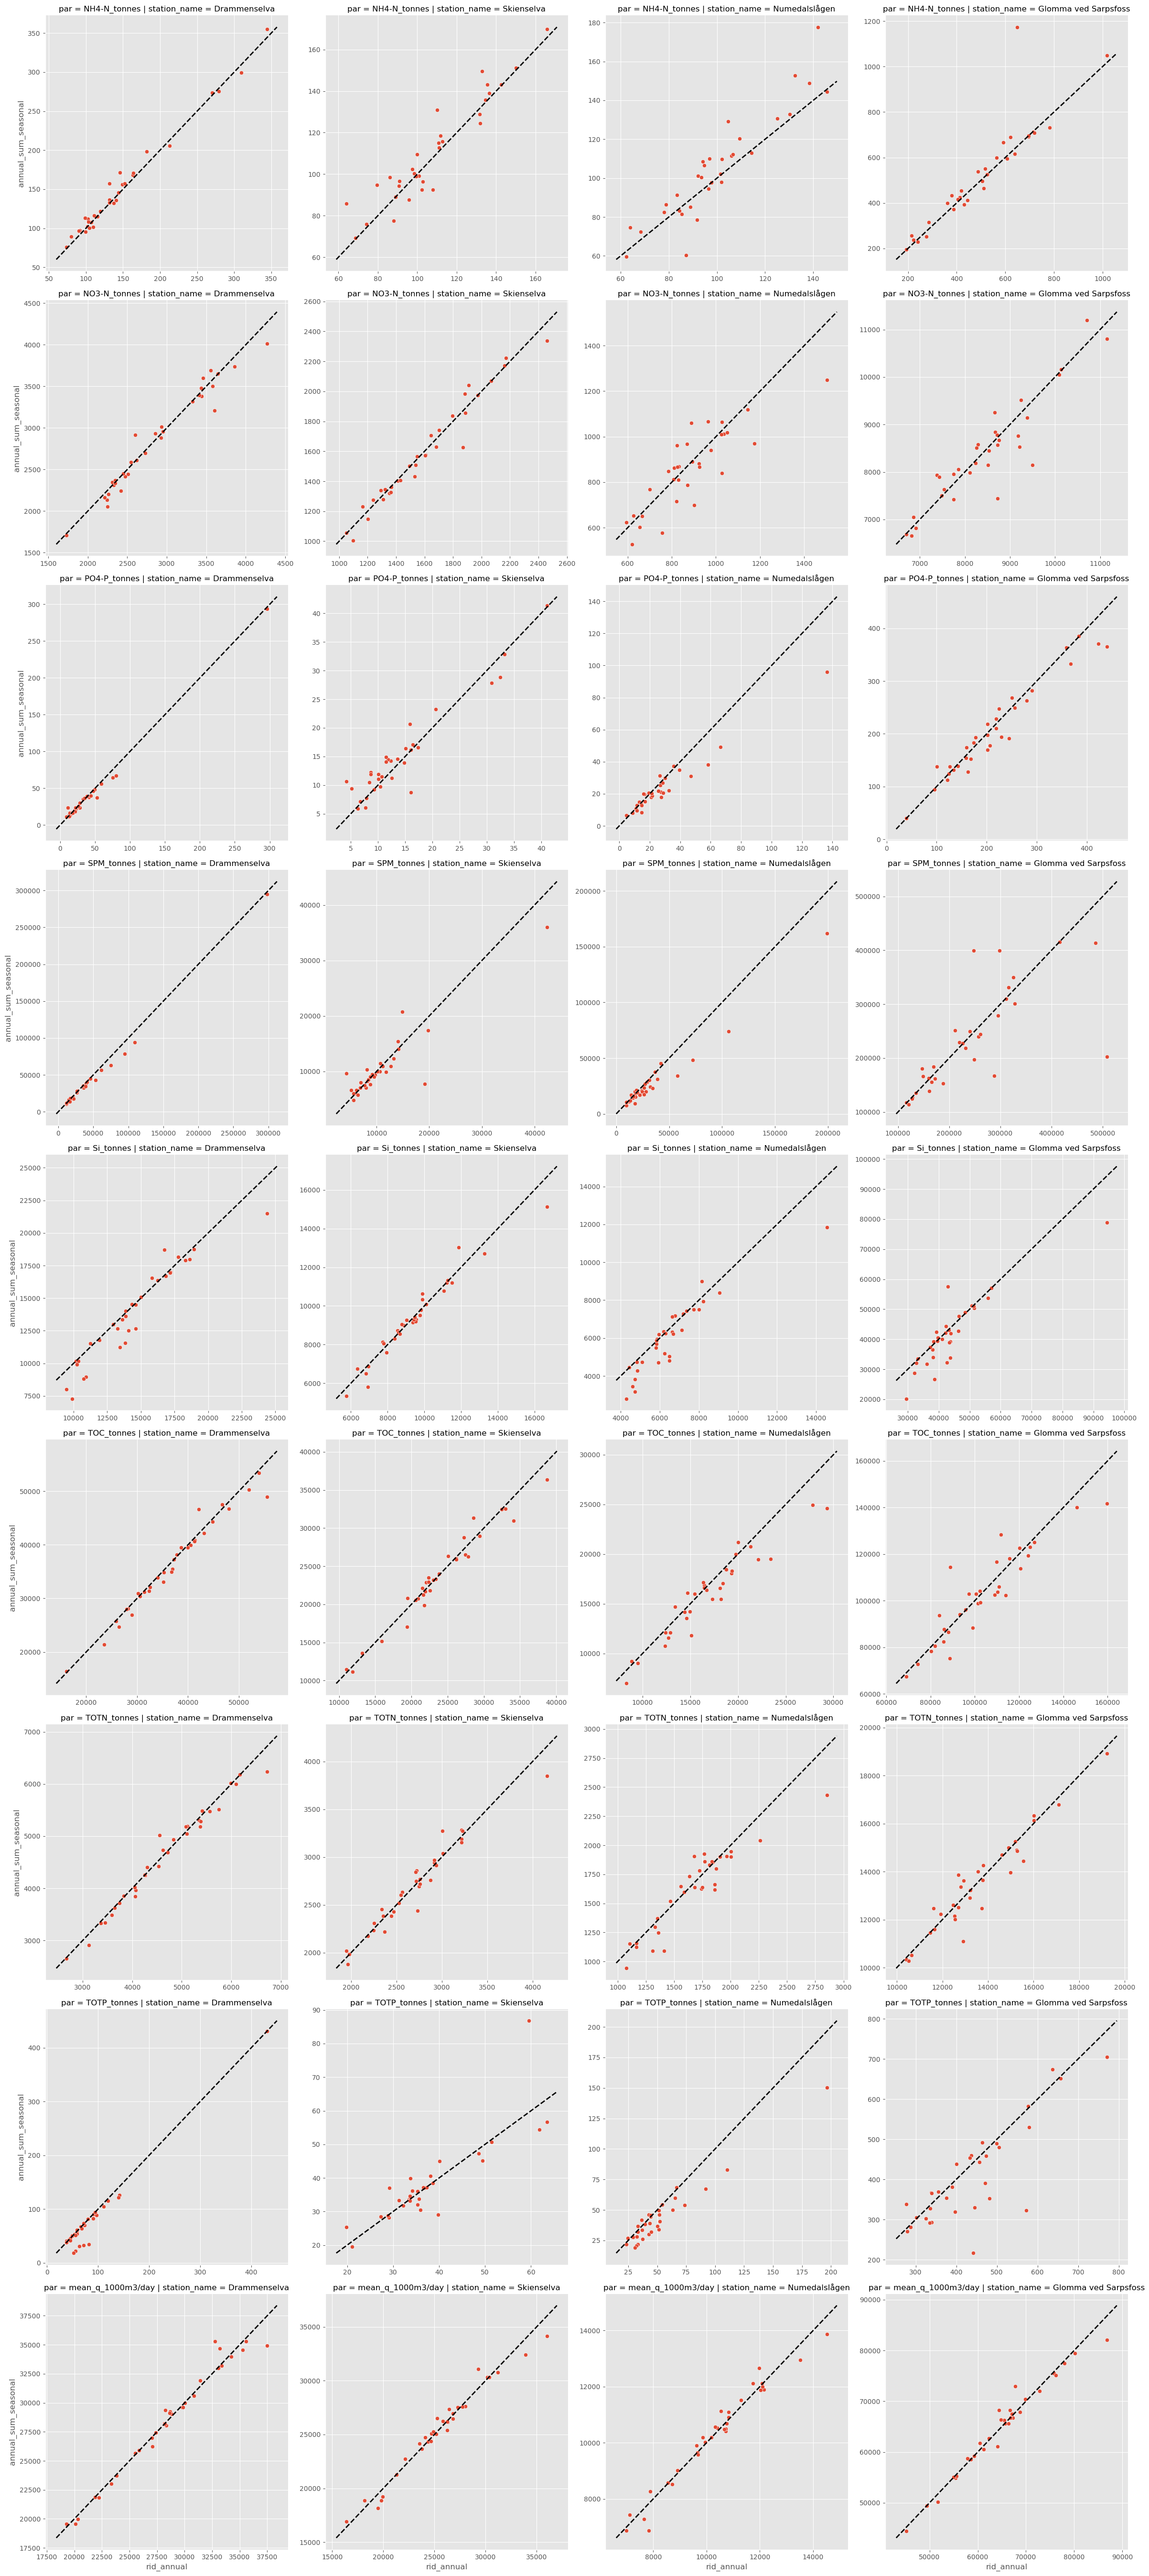

In [8]:
g = sn.relplot(
    data=ann_df,
    x="rid_annual",
    y="annual_sum_seasonal",
    col="station_name",
    row="par",
    kind="scatter",
    height=6,
    aspect=1,
    facet_kws={"sharey": False, "sharex": False},
)


# Add 1:1 line
def add_line(x, **kwargs):
    ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = x_vals
    ax.plot(x_vals, y_vals, "k--", lw=2)


g.map(add_line, "rid_annual")